# Crokinole Score Detection System - Project Notebook

**Project Objective:** Build a pipeline that reads a photo of a finished crokinole round and outputs each player's score.

---

## Project Overview

### Game Rules Summary
- **Ring Scoring:** 5, 10, 15 points for outer, middle, inner rings
- **Center (20 points):** Only if disc is completely in hole and flat (removed during play)
- **Line Touch Rule:** Disc touching a ring line gets the lower value
- **Out of Bounds:** On or beyond outer line = 0 points
- **Scoring Modes:** Cancellation scoring + Tournament round points (2-0, 1-1, etc.)

### Pipeline Overview
1. Pre-process image (colour balance, contrast, glare reduction)
2. Detect outer and inner circles and validate board (validate as crokinole board or reject)
3. Semantic segmentation (detect scoring regions)
4. Object detection (find discs as circles)
5. Colour grouping (split into two teams)
6. Score calculation (apply game rules)
7. User input for 20s (removed discs)
8. Output results with overlay visualization

---

## Setup and Configuration

### Import Required Libraries
Import all necessary libraries for image processing, visualization, and data handling.

In [1]:
# Core imports for the entire project
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, util, color, feature, transform, draw, filters, morphology
import json
import os
from pathlib import Path
import Crokinole as crk
from config import DEFAULT_CONFIG
from importlib import reload
reload(crk)

<module 'Crokinole' from '/Users/rudrapatel/Desktop/CMPT819/a1/Project/CMPT819-Project/Crokinole.py'>

Load Image

In [2]:
# Load and preprocess image
img_raw = io.imread('images/board5.jpg')
img = img_raw
preprocessed_img = crk.preprocess_image(img_raw, max_dimension=1200)

print(f"Original image shape: {img.shape}, dtype: {img.dtype}")
print(f"Preprocessed image shape: {preprocessed_img.shape}, dtype: {preprocessed_img.dtype}")

Original image shape: (1024, 1024, 3), dtype: uint8
Preprocessed image shape: (1024, 1024, 3), dtype: uint8


### Configuration Parameters
Define all system parameters, thresholds, and settings. Lock these before running on held-out test set.

In [3]:
# Configuration dictionary - loaded from config.py
CONFIG = DEFAULT_CONFIG.copy()
CONFIG['verbose'] = True  # Enable verbose output for testing

print("Configuration loaded successfully")

Configuration loaded successfully


---

## STEP 1: Image Pre-processing

**Goal:** Improve photo quality so lines and discs are clearer.

**Tasks:**
- Colour balancing to neutralize tint
- Gentle contrast boost for clearer edges
- Reduce small glares
- Prepare image for board detection

**Implementation notes:** Use histogram equalization or white balance algorithms. Apply mild gaussian blur for glare reduction?

### 1.1: Display Test Image

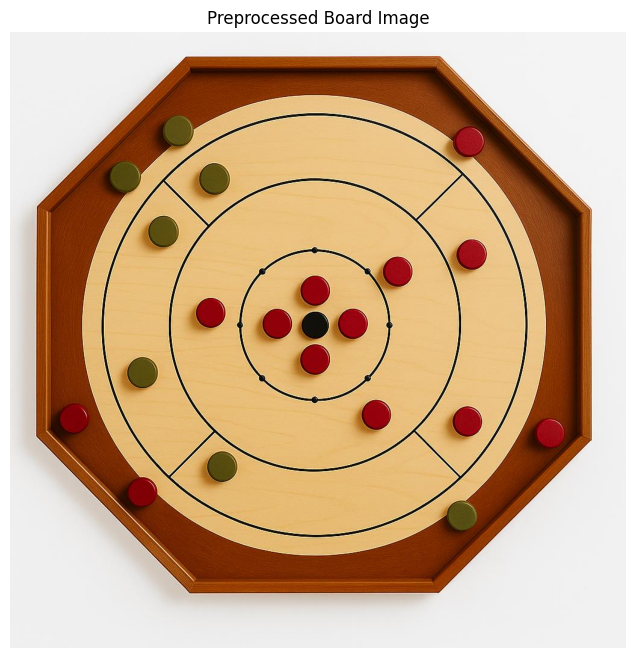

In [4]:
crk.display_image(preprocessed_img, title="Preprocessed Board Image")

---

## STEP 2: Board Detection and Validation

**Goal:** Detect the crokinole board and validate the image as a valid board, or reject it.

**Tasks:**
- Find large outer circle (board boundary)
- Detect inner ring pattern
- Verify ring spacing ratios match crokinole board
- Reject if pattern unclear or doesn't match

**Implementation notes:** Use Hough Circle Transform for outer circle. Check for concentric rings at expected ratios. Pattern check along radial lines from center.

### 2.1: Edge Detection for Board Finding

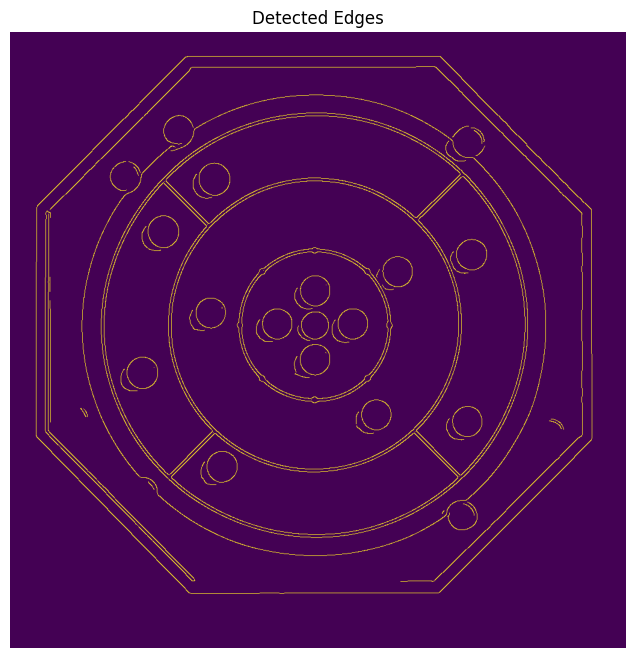

In [5]:
# Detect edges using Canny edge detection
edges = crk.detect_edges(preprocessed_img, CONFIG)

# Visualize edges
crk.display_image(edges, title="Detected Edges", figsize=(8, 8))

### 2.2: Detect Board and Rings (Outer Circle + Inner Rings)

Image dimensions: 1024x1024, Radius range: 12-921
Adaptive step size: 4 (base: 2)
Running single Hough transform for 228 radii...
Found 120 circles total
Ring5 minimum radius: 243 (min_radius=256, max_radius=921)
Circle radius range: 12 to 388
Ring5 candidates (radius >= 243): 10
Top 5 ring5 candidates: [388, 384, 352, 352, 352]
    Found ring_10: radius=240, center=(507, 482)
    Found ring_15: radius=124, center=(505, 484)
    Calculated center: radius=19, center=(506, 483)
Board found: centre=(506, 483) outer_radius≈388 (from ring_5=388.0)
  Detected rings:
    ring_5: r=388, center=(506, 482)
    ring_10: r=240, center=(507, 482)
    ring_15: r=124, center=(505, 484)
    center: r=19, center=(506, 483)
Board detected: center=(506, 483), radius=388
Detected 4 rings: ['ring_5', 'ring_10', 'ring_15', 'center']

VALID BOARD - 4/4 rings detected


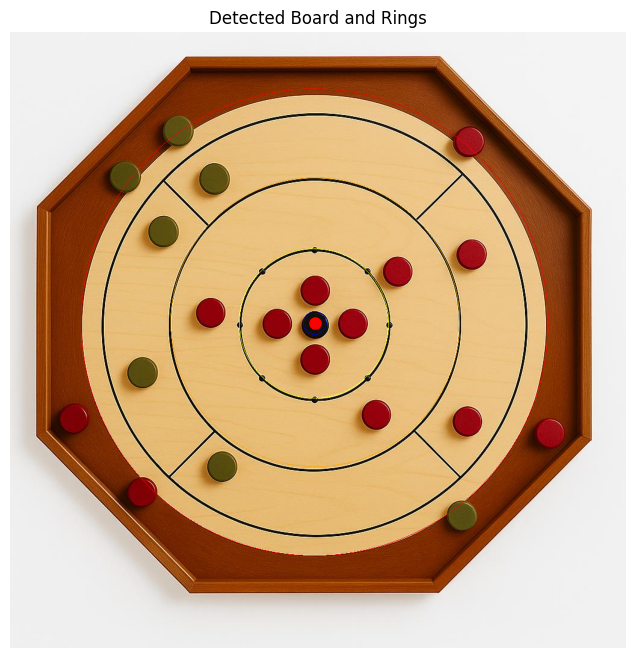

In [6]:
board_result = crk.detect_board_and_rings(edges, CONFIG)

if board_result is not None:
    board_center = board_result['center']
    board_radius = board_result['radius']
    detected_rings = board_result['rings']
    
    print(f"Board detected: center={board_center}, radius={board_radius}")
    print(f"Detected {len(detected_rings)} rings: {list(detected_rings.keys())}")
    
    # Validation: Check if we found enough rings
    min_rings = CONFIG['board_validation']['min_rings_required']
    
    if len(detected_rings) >= min_rings:
        print(f"\nVALID BOARD - {len(detected_rings)}/4 rings detected")
    else:
        print(f"\nWARNING: Only {len(detected_rings)}/4 rings detected (below minimum of {min_rings})")
    
    crk.visualize_board_detection(preprocessed_img, board_result)
else:
    board_center = None
    board_radius = None
    detected_rings = None
    print("REJECTED: Not a valid crokinole board - could not detect ring pattern")

---

## STEP 3: Semantic Segmentation - Scoring Regions

**Goal:** Map the scoring regions (rings) on the straightened board image.

**Tasks:**
- Use detected rings to define scoring region boundaries
- Create segmentation mask with regions: center (20), inner (15), middle (10), outer (5), outside (0)
- Handle line-touch rule: disc touching line gets lower value
- Visualize segmentation overlay

**Implementation notes:** Use ring radii from detection. Create labeled regions. Consider buffer zones at ring boundaries for line-touch detection.

### 3.1: Create Scoring Region Mask

In [7]:
if board_result is not None:
    # Step 4: scoring mask from library
    scoring_mask = crk.create_scoring_regions(preprocessed_img.shape, board_result)
    print(f"Scoring regions created: {np.unique(scoring_mask)}")
    print(f"Mask shape: {scoring_mask.shape}")

    # Simple line_band: no special "line" pixels yet (all False)
    line_band = np.zeros_like(scoring_mask, dtype=bool)

    # board_info structure expected by calculate_disc_scores
    board_info = {
        "center": board_result["center"],
        "radii": {
            "center": board_result["rings"]["center"]["radius"],
            "ring_5": board_result["rings"]["ring_5"]["radius"],
        },
    }
else:
    scoring_mask = None
    line_band = None
    board_info = None
    print("No board detected, cannot create scoring regions")


Scoring regions created: [ 0  5 10 15 20]
Mask shape: (1024, 1024)


### 3.2: Visualize Scoring Regions

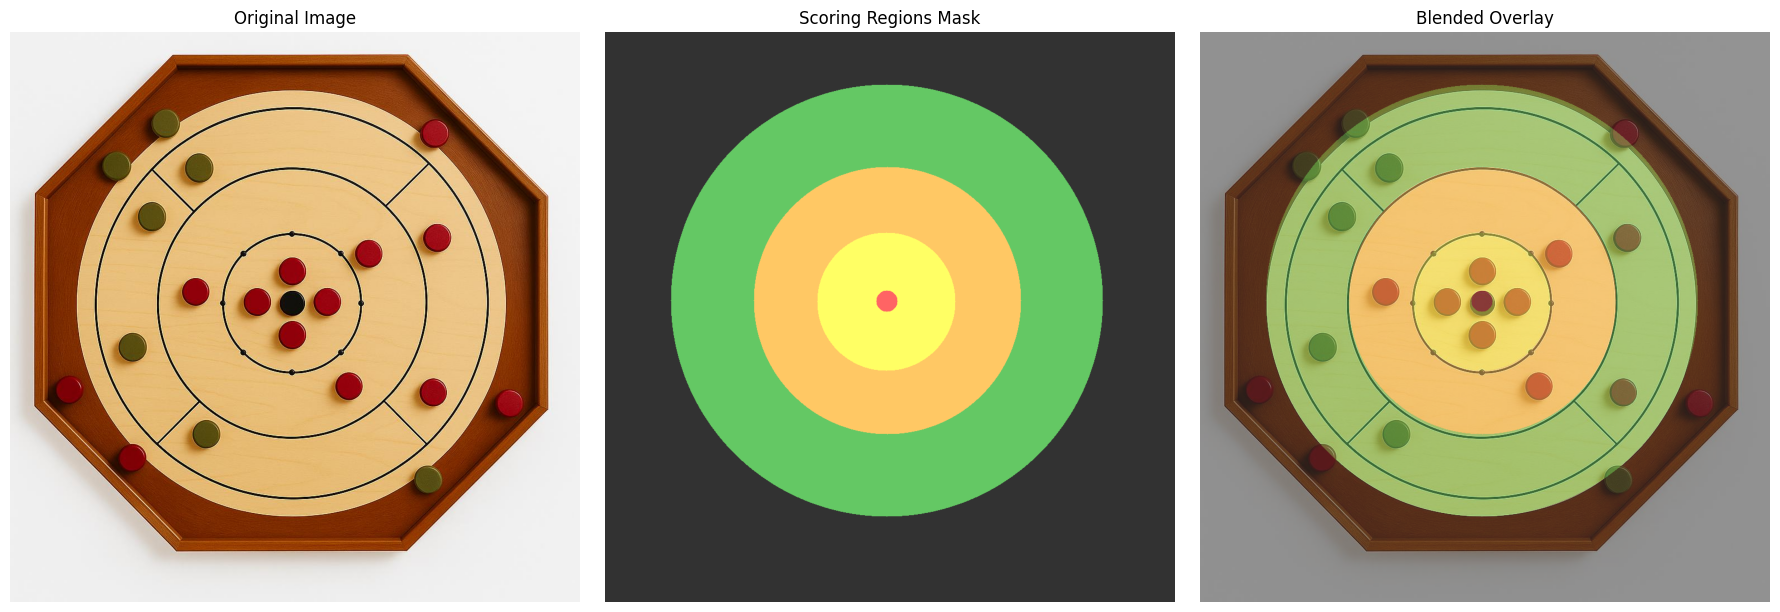

Scoring regions: [np.uint8(0), np.uint8(5), np.uint8(10), np.uint8(15), np.uint8(20)] points
  0pt region: 575687 pixels (54.9%)
  5pt region: 291972 pixels (27.8%)
  10pt region: 132616 pixels (12.6%)
  15pt region: 47172 pixels (4.5%)
  20pt region: 1129 pixels (0.1%)


In [8]:
if scoring_mask is not None:
    crk.visualize_scoring_regions(preprocessed_img, scoring_mask)
else:
    print("No scoring mask available to visualize")

---

## STEP 4: Disc Detection (Object Detection)

**Goal:** Find all crokinole discs on the board.

**Tasks:**
- Detect small circles (discs) within expected size range
- Use two-pass strategy: strict pass first, fallback if needed
- Filter duplicates and ensure minimum spacing
- Limit to maximum 28 discs (12 per team + extras)
- Mask detection to board area only

### 4.1: Detect Discs using Hough Circle Transform

[DD] board_brightness=0.764 → generic preset path
[DD] preset=light_wood_hard


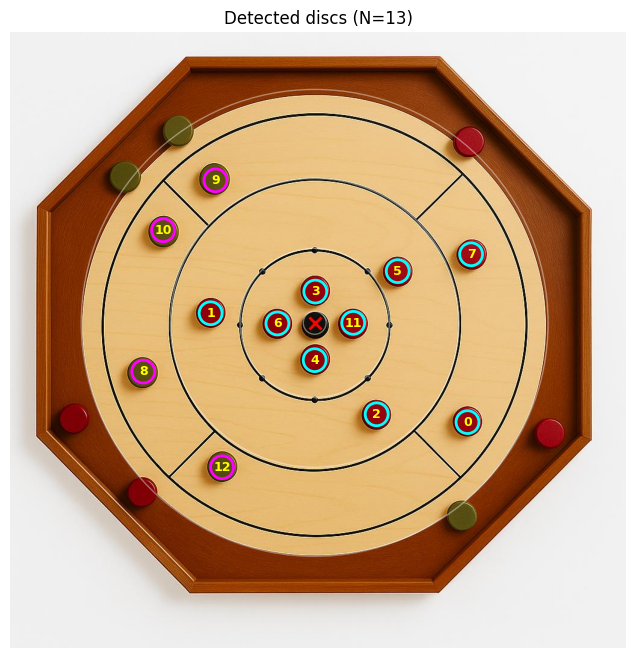

In [9]:
if board_result is not None:
    discs = crk.detect_discs(preprocessed_img, board_result, CONFIG)
else:
    discs = []
    print("No board detected, cannot detect discs")

---

## STEP 5: Colour Grouping (Team Assignment)

**Goal:** Split detected discs into two teams based on colour.

**Tasks:**
- Extract colour from each disc region
- Use clustering (k-means, k=2) to group into two teams
- Handle edge cases: similar colours, uncertain assignments
- Flag low-confidence assignments for user verification

**Implementation notes:** Sample colour from disc center. Use HSV or LAB colour space. Calculate colour similarity score between teams.

### 5.1: Extract Disc Colours

In [10]:
if len(discs) > 0:
    # Extract Lab color features from already detected discs
    disc_features = crk.extract_disc_colours(preprocessed_img, discs)
    print("Features shape:", disc_features.shape)
else:
    disc_features = None
    print("No discs detected, cannot extract disc colours")

Features shape: (13, 3)


### 5.2: Cluster into Two Teams

In [11]:
if disc_features is not None:
    team_assignments, centroids = crk.cluster_teams_lab(disc_features, CONFIG['colour_grouping']['n_clusters'])
    # Remap so Team 0 = light (white), Team 1 = dark (black)
    team_assignments, centroids = crk.remap_teams_by_lightness(team_assignments, centroids)
    print(f"Team 0 (light) L-value: {centroids[0, 0]:.1f}, Team 1 (dark) L-value: {centroids[1, 0]:.1f}")
else:
    team_assignments = None
    centroids = None

Team 0 (light) L-value: 33.0, Team 1 (dark) L-value: 30.9


### 5.3: Check Colour Similarity and Flag Uncertain Assignments

In [12]:
if disc_features is not None and team_assignments is not None:
    similarity, uncertain_discs = crk.check_colour_similarity(disc_features, team_assignments)
    print(f"Colour ΔE (ab): {similarity:.2f}. Uncertain discs: {len(uncertain_discs)}")
else:
    similarity = None
    uncertain_discs = []

Colour ΔE (ab): 56.76. Uncertain discs: 0


---

## STEP 6: Score Calculation (Apply Game Rules)

**Goal:** Calculate score for each disc based on its position and game rules.

**Tasks:**
- For each disc, determine which scoring region it occupies
- Apply line-touch rule: if disc touches boundary, give lower value
- Handle center hole (20pt): only if disc fully inside and flat
- Assign 0 points to discs outside outer boundary
- Flag edge cases for review (overlapping discs, disc on peg, uncertain position)

**Implementation notes:** Use scoring mask from Step 4. Sample multiple points around disc perimeter to detect line touches. Use disc radius to check if fully within center hole.

### 6.1: Assign Score to Each Disc

In [13]:
if len(discs) > 0 and scoring_mask is not None and line_band is not None and board_info is not None:
    disc_scores = crk.calculate_disc_scores(discs, scoring_mask, line_band, board_info)

    for ds in disc_scores:
        mark = "!" if ds.flags else "✓"
        print(f"{mark} disc {ds.idx}: {ds.score} pts, conf={ds.confidence:.2f}, flags={ds.flags}")
else:
    disc_scores = None
    print("No discs detected, cannot calculate scores")

✓ disc 0: 5 pts, conf=1.00, flags=[]
✓ disc 1: 10 pts, conf=1.00, flags=[]
✓ disc 2: 10 pts, conf=1.00, flags=[]
✓ disc 3: 15 pts, conf=1.00, flags=[]
✓ disc 4: 15 pts, conf=1.00, flags=[]
✓ disc 5: 10 pts, conf=1.00, flags=[]
✓ disc 6: 15 pts, conf=1.00, flags=[]
✓ disc 7: 5 pts, conf=1.00, flags=[]
✓ disc 8: 5 pts, conf=1.00, flags=[]
✓ disc 9: 5 pts, conf=1.00, flags=[]
✓ disc 10: 5 pts, conf=1.00, flags=[]
✓ disc 11: 15 pts, conf=1.00, flags=[]
✓ disc 12: 5 pts, conf=1.00, flags=[]


### 6.2: Calculate Team Totals (Visible Discs Only)

In [14]:
if disc_scores is not None and team_assignments is not None:
    team1_visible, team2_visible = crk.calculate_team_totals(disc_scores, team_assignments)
    print(f"Visible totals -> Team 0: {team1_visible}, Team 1: {team2_visible}")
else:
    team1_visible = 0
    team2_visible = 0
    print("No disc scores or team assignments, cannot calculate team totals")

Visible totals -> Team 0: 20, Team 1: 100


---

## STEP 7: User Input for 20-Point Discs

**Goal:** Get count of 20-point discs for each player (removed during play).

**Tasks:**
- Prompt user for Team 1's count of 20-point discs
- Prompt user for Team 2's count of 20-point discs
- Validate input (reasonable range, e.g., 0-12 per team)
- Add 20×count to each team's total

**Implementation notes:** In final app, this will be CLI/web form input. For notebook testing, use Python input() or hardcode test values.

### 7.1: Get User Input for 20-Point Counts

In [15]:
# For testing, hardcode the number of 20-point discs
# In production, these would be user inputs
team1_20s = 0  # Number of 20-point discs for Team 1 (light colored)
team2_20s = 0  # Number of 20-point discs for Team 2 (dark colored)

print(f"20-point discs -> Team 0: {team1_20s}, Team 1: {team2_20s}")

20-point discs -> Team 0: 0, Team 1: 0


### 7.2: Calculate Final Totals

In [16]:
# Calculate final scores by adding 20-point discs to visible totals
# Each 20-point disc adds 20 points to the team's score
if disc_scores is not None and team_assignments is not None:
    team1_final = team1_visible + (team1_20s * 20)
    team2_final = team2_visible + (team2_20s * 20)
    
    print(f"\n{'='*50}")
    print(f"FINAL SCORES")
    print(f"{'='*50}")
    print(f"Team 0: {team1_final} pts (visible: {team1_visible}, 20s: {team1_20s}×20 = {team1_20s * 20})")
    print(f"Team 1: {team2_final} pts (visible: {team2_visible}, 20s: {team2_20s}×20 = {team2_20s * 20})")
    print(f"{'='*50}")
else:
    team1_final = 0
    team2_final = 0
    print("Cannot calculate final scores - no disc data available")


FINAL SCORES
Team 0: 20 pts (visible: 20, 20s: 0×20 = 0)
Team 1: 100 pts (visible: 100, 20s: 0×20 = 0)


---

## STEP 8: Output Results

**Goal:** Generate final output with visualization and data export.

**Tasks:**
- Create overlay image showing:
  - Detected board and rings
  - All detected discs with outlines
  - Team colour coding
  - Per-disc point values
  - Final totals
- Calculate cancellation scoring
- Calculate tournament round points (if selected)
- Export results to JSON/CSV file
- Save overlay image

**Implementation notes:** Use matplotlib for overlay. Create results dictionary with all metadata. Save to structured JSON format.

### 8.1: Create Visualization Overlay

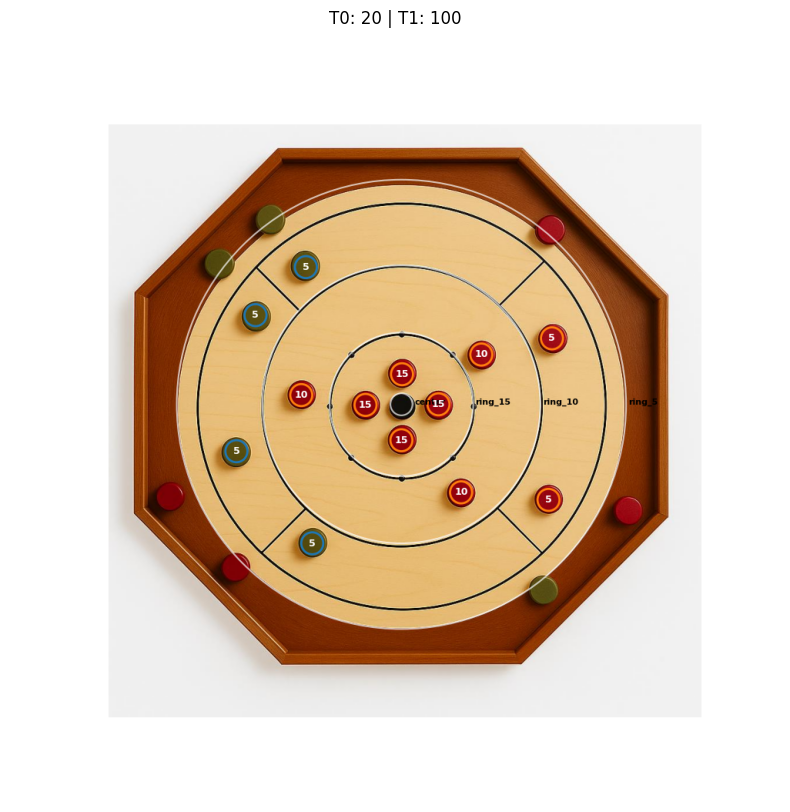

In [17]:
# Create comprehensive visualization overlay
if board_result is not None and len(discs) > 0 and team_assignments is not None and disc_scores is not None:
    overlay_img = crk.create_results_overlay(preprocessed_img, board_result, discs, team_assignments, disc_scores)
    plt.figure(figsize=(10,10)); plt.imshow(overlay_img); plt.axis('off'); plt.title(f"T0: {team1_final} | T1: {team2_final}"); plt.show()
else:
    overlay_img = None
    print("Insufficient data to create results overlay")

### 8.2: Calculate Cancellation Scoring

In [18]:
# Calculate cancellation scoring (difference only)
cancellation_score = abs(team1_final - team2_final)
winner = "Team 0" if team1_final > team2_final else ("Team 1" if team2_final > team1_final else "Tie")
print("Cancellation -> Winner:", winner, "Margin:", cancellation_score)

Cancellation -> Winner: Team 1 Margin: 80
